<a href="https://colab.research.google.com/github/lwschm/quantitative_tutorial/blob/main/QuantitativeTutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Quantitative tutorial

## Instructions

- The notebook combines 'code used during lecture' with the 'Day 2 lab' assignment (see further down)
- The lab assignment can be done largely by copying/paste/modification of the code used during the lecture
- Please add answers/discussion/comments to the notebook as comments or text box. Do not create another file in addition.


## Code used during lecture

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn import tree



In [4]:
# Set the numpy random seed
np.random.seed(100)

In [9]:
# Download data
!wget -nc https://ilr-ml.s3.eu-central-1.amazonaws.com/brazil_all_data_v2.gz

--2023-01-29 15:12:16--  https://ilr-ml.s3.eu-central-1.amazonaws.com/brazil_all_data_v2.gz
Resolving ilr-ml.s3.eu-central-1.amazonaws.com (ilr-ml.s3.eu-central-1.amazonaws.com)... 52.219.72.108
Connecting to ilr-ml.s3.eu-central-1.amazonaws.com (ilr-ml.s3.eu-central-1.amazonaws.com)|52.219.72.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 283350352 (270M) [application/x-gzip]
Saving to: ‘brazil_all_data_v2.gz’

brazil_all_data_v2. 100%[===================>] 270.22M  28.6MB/s    in 10s     

2023-01-29 15:12:27 (26.5 MB/s) - ‘brazil_all_data_v2.gz’ saved [283350352/283350352]



In [11]:
# Load data with pandas into a dataframe 
df = pd.read_parquet('brazil_all_data_v2.gz')

In [12]:
# Define binary variable for deforestration in 2018
df['D_defor_2018'] = df['defor_2018']>0
Y_all = df['D_defor_2018']

In [13]:
# Define a list of features names (explantory variables)
lstX = [
  'wdpa_2017',
  'population_2015',
  'chirps_2017',
  'defor_2017',
  'maize',
  'soy',
  'sugarcane',
  'perc_treecover',
  'perm_water',
  'travel_min',
  'cropland',
  'mean_elev',
  'sd_elev',
  'near_road',
  'defor_2017_lag_1st_order',
  'wdpa_2017_lag_1st_order',
  'chirps_2017_lag_1st_order',
  'population_2015_lag_1st_order',
  'maize_lag_1st_order',
  'soy_lag_1st_order',
  'sugarcane_lag_1st_order',
  'perc_treecover_lag_1st_order',
  'perm_water_lag_1st_order',
  'travel_min_lag_1st_order',
  'cropland_lag_1st_order',
  'mean_elev_lag_1st_order',
  'sd_elev_lag_1st_order',
  'near_road_lag_1st_order',
 ]

# Get the explanatory Variables
X_all =  df.loc[:,lstX]

In [14]:
# Split the data into train and test data using sklearn train_test_split object
#   (see: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)

#   Note: This randomly split the data in 80% train and 20% test data
X_train_raw, X_test_raw, Y_train, Y_test = train_test_split(X_all, Y_all, test_size = 0.2)

In [15]:
# Scale data to 0-1 range using sklearn MinMaxScalar object 
# (see: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) 
scaler = MinMaxScaler()
# Use only the train data to fit the MinMaxScalar 
scaler.fit(X_train_raw)

# Apply the MinMax transformation to the train and test data 
X_train = scaler.transform(X_train_raw)
X_test = scaler.transform(X_test_raw)
# Note the depended variable does not need to be scaled as it is a binary variable anyway

Run logit on deforestation binary variable

In [16]:
# Fit a logistic regression model using sklearn 
# (see: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)

# Create the model object
modelLg = LogisticRegression(random_state=0,penalty='none',fit_intercept=True,max_iter=1000)
# Fit the model using the training data
modelLg.fit(X_train, Y_train)

LogisticRegression(max_iter=1000, penalty='none', random_state=0)

In [17]:
# Define a function that prints the model statistics.
# We will use the function below to always get the same model stats for each of
# the model the we will estimate below.
def printOutput(mod,X_train,Y_train,X_test,Y_test):
  # view results
  print('Score in train', mod.score(X_train, Y_train))
  print('Score in test', mod.score(X_test, Y_test))

  Y_test_had_Tree = mod.predict(X_test)

  print('\nConfusion Matrix')
  print(pd.DataFrame(confusion_matrix(Y_test, Y_test_had_Tree),
            index=pd.MultiIndex.from_arrays([['actual','actual'], ['False','True']]),
            columns=pd.MultiIndex.from_arrays([['predicted','predicted'], ['False','True']])))

In [18]:
# Use the function to print the model statistics for our logit model 
printOutput(modelLg,X_train,Y_train,X_test,Y_test)

# Compute ROC curve and ROC area for each class

# Get the predicted probabiltities 
Y_score = modelLg.decision_function(X_test)

# Get true positive and false positive rate
# See: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html
fpr_Lg, tpr_Lg, _ = roc_curve(Y_test, Y_score)

# Get the Area under the cureve (AUC)
# See: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.auc.html
roc_auc_Lg = auc(fpr_Lg, tpr_Lg)

print('\nROC AUC', roc_auc_Lg)

Score in train 0.7861336720812995
Score in test 0.7838281187484997

Confusion Matrix
             predicted      
                 False  True
actual False     36625  1314
       True       9492  2557

ROC AUC 0.7652691452966887


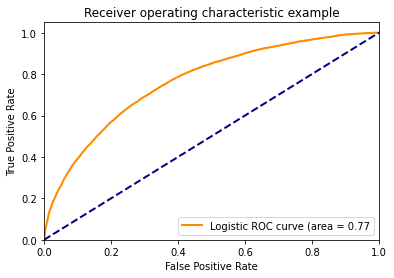

In [19]:
# Plot the ROC curve
plt.figure()
lw = 2
plt.plot(fpr_Lg, tpr_Lg, color='darkorange',
         lw=lw, label='Logistic ROC curve (area = %0.2f' % roc_auc_Lg)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

Now run a decision tree using the same specification

In [20]:
# Fit a decision tree using sklearn
# (see https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)

# Define a model object
modelTree = tree.DecisionTreeClassifier()
# Fit the model
modelTree = modelTree.fit(X_train, Y_train)

In [21]:
# Use the function to print the model statistics for our tree model 
printOutput(modelTree,X_train,Y_train,X_test,Y_test)

Score in train 1.0
Score in test 0.7643034328238777

Confusion Matrix
             predicted      
                 False  True
actual False     31990  5949
       True       5833  6216


Run the same model using  a random forest

In [22]:
# run a random forest using sklearn and default hyperparameters (note, this will take a few minutes)
# (see https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
from sklearn.ensemble import RandomForestClassifier

# Create model object
modelForest = RandomForestClassifier()
# Fit model
modelForest = modelForest.fit(X_train, Y_train)

In [23]:
# Print model output stats
printOutput(modelForest,X_train,Y_train,X_test,Y_test)


Score in train 0.9999749939985596
Score in test 0.8354605105225255

Confusion Matrix
             predicted      
                 False  True
actual False     35571  2368
       True       5857  6192


In [24]:
# ====================
# Discuss in the group
# ====================
# What do you conclude from the model outcome. Is this a 
# useful model. Compare the results to the logit outcomes. 

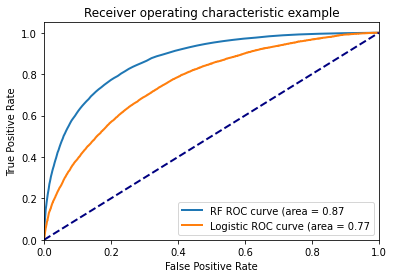

In [25]:
# Plot ROC curve 
# Get the predicted probabiltities 
Y_scoreRF = modelForest.predict_proba(X_test)[:,1]

# Get true positive and false positive rate
fpr_RF, tpr_RF, _ = roc_curve(Y_test, Y_scoreRF)

# Get the Area under the cureve (AUC)
roc_auc_RF = auc(fpr_RF, tpr_RF)


plt.figure()
lw = 2
plt.plot(fpr_RF, tpr_RF, 
         lw=lw, label='RF ROC curve (area = %0.2f' % roc_auc_RF)
plt.plot(fpr_Lg, tpr_Lg, 
         lw=lw, label='Logistic ROC curve (area = %0.2f' % roc_auc_Lg)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

Visualizing the results

Feature ranking:
1. wdpa_2017 (0.153773)
2. population_2015 (0.076315)
3. chirps_2017 (0.050062)
4. defor_2017 (0.044067)
5. maize (0.037960)
6. soy (0.037260)
7. sugarcane (0.036292)
8. perc_treecover (0.036261)
9. perm_water (0.035162)
10. travel_min (0.034423)
11. cropland (0.033846)
12. mean_elev (0.033821)
13. sd_elev (0.033135)
14. near_road (0.031709)
15. defor_2017_lag_1st_order (0.031653)
16. wdpa_2017_lag_1st_order (0.030303)
17. chirps_2017_lag_1st_order (0.029846)
18. population_2015_lag_1st_order (0.029357)
19. maize_lag_1st_order (0.029184)
20. soy_lag_1st_order (0.028095)
21. sugarcane_lag_1st_order (0.025069)
22. perc_treecover_lag_1st_order (0.024183)
23. perm_water_lag_1st_order (0.023978)
24. travel_min_lag_1st_order (0.023328)
25. cropland_lag_1st_order (0.021272)
26. mean_elev_lag_1st_order (0.014762)
27. sd_elev_lag_1st_order (0.008199)
28. near_road_lag_1st_order (0.006685)


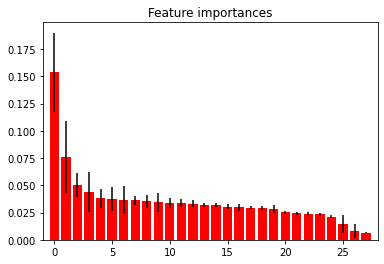

In [26]:
# Generate a feature importance graph for the forest
# Adjusted based on  https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html

importances = modelForest.feature_importances_
std = np.std([tree.feature_importances_ for tree in modelForest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")


for f in range(X_train.shape[1]):
    print("%d. %s (%f)" % (f + 1, lstX[f], importances[indices[f]]))

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
# plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()

# Lab

The lab today will have you predict deforestation using both a random forest and XGboost models

In [27]:


# In the lecture part we have run a Random Forest that heavily 
# overfitted the training data. Adjust a hyperparamter 
# and see if you can train a model that does not overfit.

# Hint: Vary the parameter max_depth or min_samples_split

# Sklearn documentation on RF:
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier.predict_proba

# ==============
# Your code here
# ==============
modelForest = ...

# Fit model
...

#  Print model stats output
printOutput(...)

NameError: ignored

In [ ]:
# Now run an XGBoost model for the same task 
import xgboost as xgb

# Hint: 1) Look at one of the tutorial on XGB on how to specify and run the model
#          (e.g. https://hackernoon.com/want-a-complete-guide-for-xgboost-model-in-python-using-scikit-learn-sc11f31bq) 
#       2) You do not need to adjust hypterparamter here. The default paramters
#          should be fine here.

# ==============
# Your code here
# ==============
# Specify model 
model_xgb = ...


# Fit model to data
model_xgb ...


In [ ]:
# Print the model stats of you XGB model using the function from above
# ==============
# Your code here
# ==============
...



In [ ]:
# Compare to the outcome of the other model 
# (not need to change anything here) 
print('\n--- Logistic')
printOutput(modelLg,X_train,Y_train,X_test,Y_test)

print('\n--- Tree')
printOutput(modelTree,X_train,Y_train,X_test,Y_test)

print('\n--- Forest')
printOutput(modelForest,X_train,Y_train,X_test,Y_test)


In [ ]:
# Write a couple of sentences on what you see in your models, which you 
# believe are performing better and why
# ================
# Your answer here
# ================




In [ ]:
# Plot an ROC corve for the Logit, Random Forest and XGB model 

# Hint: Check what we have done above... 
# ==============
# Your code here
# ==============
# Get the predicted probabiltities 
Y_scoreXG = ...

# Get true positive and false positive rate
fpr_XG, tpr_XG, _ = ...

# Get the Area under the cureve (AUC)
roc_auc_XG = ...



In [ ]:
# Plot the figure (not need to change anything here)
plt.figure()
lw = 2

plt.plot(fpr_XG, tpr_XG, 
         lw=lw, label='XG ROC curve (area = %0.2f' % roc_auc_XG)

plt.plot(fpr_Lg, tpr_Lg, 
         lw=lw, label='Logistic ROC curve (area = %0.2f' % roc_auc_Lg)

plt.plot(fpr_RF, tpr_RF, 
         lw=lw, label='RF ROC curve (area = %0.2f' % roc_auc_RF)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# In one or two sentences, discuss what the ROC curves are telling you 
# ================
# Your answer here
# ================



### Optional Tasks

(Optional) Generate your model's prediction errors and explore them - comparing different subsets of your data (e.g. protected areas vs others)